<a href="https://colab.research.google.com/github/VimalRency/Spectogram/blob/main/classification_of_spectrogram_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import librosa
import soundfile as sf


In [15]:
def load_spectrogram_images_with_psd(data_dir, img_size=(128, 128), sr=22050):
    features = []
    labels = []

    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.png'):
                img_path = os.path.join(root, file)
                try:
                    img = load_img(img_path, target_size=img_size)
                    img = img_to_array(img)
                    img = np.mean(img, axis=2)  # Convert to grayscale by averaging channels

                    # Compute PSD
                    freqs, psd = plt.psd(img.flatten(), NFFT=1024, Fs=sr)
                    plt.title(f'Power Spectral Density - {file}')
                    plt.xlabel('Frequency (Hz)')
                    plt.ylabel('Power/Frequency (dB/Hz)')
                    plt.savefig(f"{os.path.splitext(file)[0]}_psd.png")
                    plt.close()

                    features.append(img)
                    labels.append(os.path.basename(root))  # Use directory name as label
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

    features = np.array(features)
    labels = np.array(labels)
    return features, labels


In [16]:
data_dir = '/content/drive/MyDrive/spec1'  # Update this path to your actual data directory
img_size = (128, 128)
X, y = load_spectrogram_images_with_psd(data_dir, img_size=img_size)


In [17]:
X_flattened = X.reshape(len(X), -1)

# Encode class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y_encoded, test_size=0.2, random_state=42)

# Train SVM
svm_model = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
svm_model.fit(X_train, y_train)


SVC(kernel='linear', probability=True, random_state=42)

In [18]:
def predict_reconstruct_with_psd(model, img_path, label_encoder, img_size=(128, 128), sr=22050, threshold=0.5):
    # Load and preprocess the image
    img = load_img(img_path, target_size=img_size)
    img = img_to_array(img)
    img = np.mean(img, axis=2)  # Convert to grayscale by averaging channels

    # Compute PSD
    freqs, psd = plt.psd(img.flatten(), NFFT=1024, Fs=sr)
    plt.title(f'Power Spectral Density - {os.path.basename(img_path)}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.savefig(f"{os.path.splitext(os.path.basename(img_path))[0]}_psd.png")
    plt.close()

    # Flatten the spectrogram image
    img_flattened = img.flatten().reshape(1, -1)

    # Predict the class
    probabilities = model.predict_proba(img_flattened)
    max_prob = np.max(probabilities)

    if max_prob < threshold:
        predicted_class = 'unknown'
    else:
        predicted_class_index = np.argmax(probabilities)
        predicted_class = label_encoder.inverse_transform([predicted_class_index])[0]

    # Reconstruct the audio
    power_spectrogram = np.expm1(img_flattened.reshape(img_size))
    amplitude_spectrogram = np.sqrt(power_spectrogram)
    reconstructed_audio = librosa.istft(amplitude_spectrogram)

    # Save the reconstructed audio to a file
    output_audio_path = os.path.splitext(img_path)[0] + "_reconstructed.wav"
    sf.write(output_audio_path, reconstructed_audio, sr)

    return predicted_class, output_audio_path, reconstructed_audio


In [19]:
# Example usage for a test image
test_img_path = '/content/WhatsApp Image 2024-07-04 at 10.28.53_e960528a.jpg'  # Update with your test image path
predicted_class, output_audio_path, reconstructed_audio = predict_reconstruct_with_psd(
    svm_model, test_img_path, label_encoder, img_size=img_size, sr=22050, threshold=0.5
)

print(f'Predicted Class: {predicted_class}')
print(f'Reconstructed Audio Path: {output_audio_path}')


Predicted Class: no
Reconstructed Audio Path: /content/WhatsApp Image 2024-07-04 at 10.28.53_e960528a_reconstructed.wav


<ipython-input-18-bfe519e3247c>:29: RuntimeWarning: overflow encountered in expm1
  power_spectrogram = np.expm1(img_flattened.reshape(img_size))
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:566: RuntimeWarning: invalid value encountered in multiply
  ytmp = ifft_window * fft.irfft(stft_matrix[..., :start_frame], n=n_fft, axis=-2)
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:598: RuntimeWarning: invalid value encountered in multiply
  ytmp = ifft_window * fft.irfft(stft_matrix[..., bl_s:bl_t], n=n_fft, axis=-2)


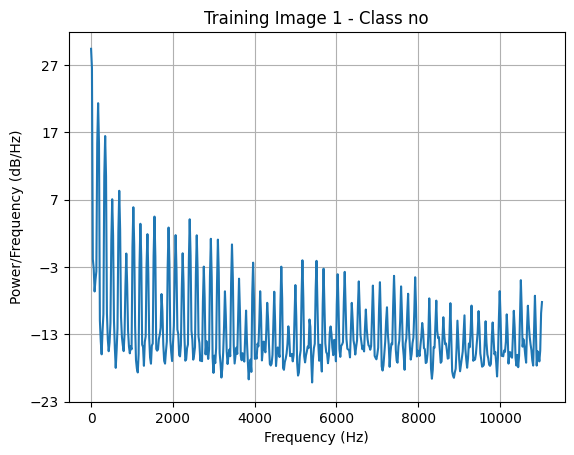

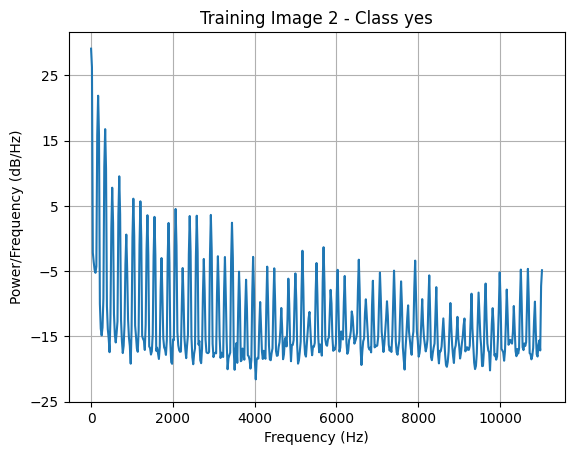

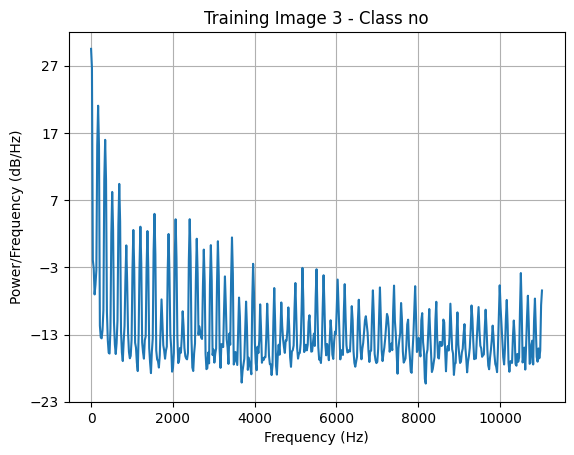

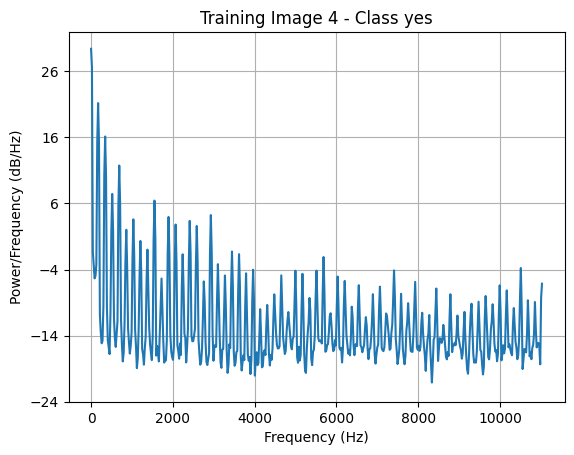

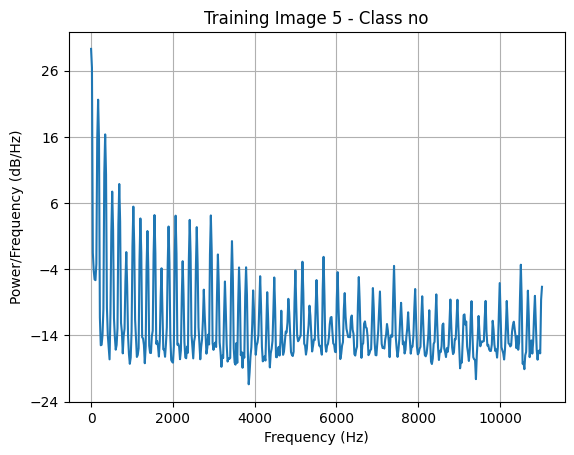

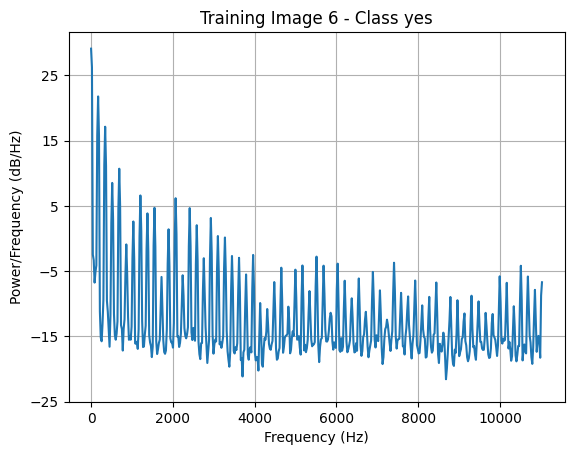

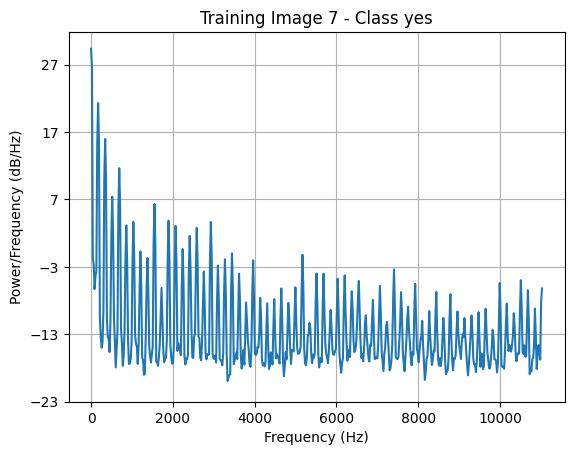

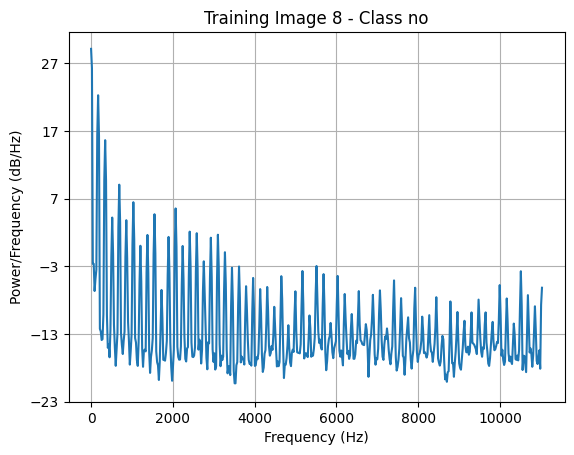

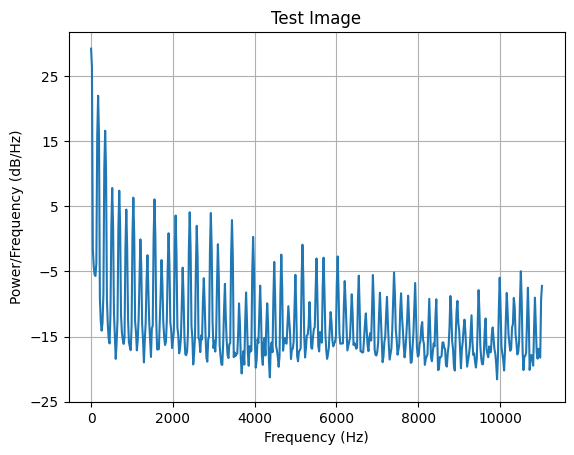

In [20]:
def plot_psd(img, title, sr=22050):
    freqs, psd = plt.psd(img.flatten(), NFFT=1024, Fs=sr)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.show()

# Plot PSD for each training image
for i, img in enumerate(X_train):
    plot_psd(img.reshape(img_size), f'Training Image {i+1} - Class {label_encoder.inverse_transform([y_train[i]])[0]}')

# Plot PSD for the test image
test_img = load_img(test_img_path, target_size=img_size)
test_img = img_to_array(test_img)
test_img = np.mean(test_img, axis=2)
plot_psd(test_img, 'Test Image')
